<a href="https://colab.research.google.com/github/lorenz0leoncin1/project_users_forecasting/blob/main/Boston_Scientific_Data_Scientist_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#First import the Boston Scientific - Data Scientist - Task.xlsx file into the workspace

# Models for User Prediction & Forecasting

### Roadmap with Key Points

#### Models considered:
- Linear Regression
- Prophet
- XGBoost

---

For each model, we have followed the key steps:

1. **Data Preparation**:
   - **Linear Regression**: Normalization of data and creation of dummy variables for categorical features.
   - **Prophet**: Formatting data to meet model requirements (dataframe with 'ds' and 'y' columns).
   - **XGBoost**: Transformation of data into a format compatible with the model.

2. **Train/Test Split**:
   - Division of the dataset into training and test sets, preserving the time sequence.

3. **Time Series Cross-Validation(for Linear Regression & XGBoost)**:
   - Application of time series cross-validation to assess model robustness, ensuring future data does not influence the models.

4. **Feature Engineering**:
   - Creation of lags, rolling means, and other significant features based on domain knowledge.

5. **Correlation Analysis**:
   - Analysis of correlation between variables to identify the most relevant features.

6. **Handle Missing Values**:
   - Development of strategies for handling missing values, including interpolation and replacement with mean or rolling mean values.

7. **Model Training and Evaluation**:
   - Training each model using the training set and evaluating performance through appropriate metrics (e.g., RMSE, MAE, WMAE).

8. **Future Predictions**:
   - Execution of future predictions using the trained model, considering the predicted variables and model parameters.

9. **Model Persistence**:
   - Saving trained models for future use, allowing avoidance of reconstruction each time.

10. **Visualization of Predictions**:
    - Creation of plots to visualize predictions against actual values, enabling visual analysis of model performance over time.


Considerations:
**ARIMA** is an interesting option but it hasn't been implemented

## Short Data  **Exploratory Analysis**

In [366]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
df = pd.read_excel("Boston Scientific - Data Scientist - Task.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Users,Lockdown_flag,Campaigns_flag
Date,,,
2017-01-11,1,0,0
2017-01-12,1,0,0
2017-01-13,1,0,0
2017-01-14,1,0,0
2017-01-15,3,0,0


In [368]:
df.describe()

,Users,Lockdown_flag,Campaigns_flag
count,1602.000000,1602.000000,1602.000000
mean,8.307116,0.053683,0.005618
std,10.510068,0.225461,0.074766
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000
75%,11.000000,0.000000,0.000000
max,109.000000,1.000000,1.000000


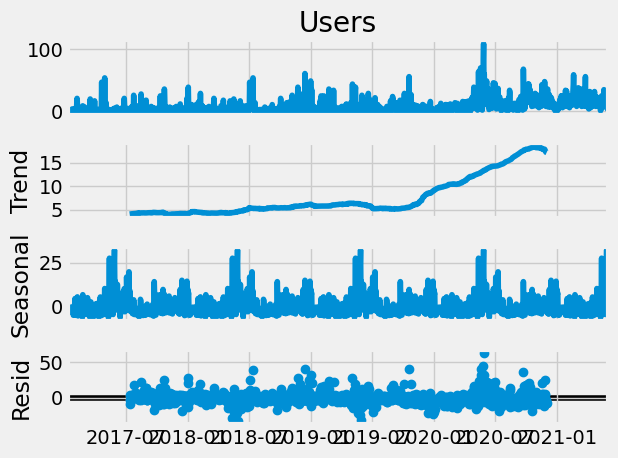

In [369]:
decomposition = seasonal_decompose(df['Users'], model='additive', period=365)
decomposition.plot()
plt.show()


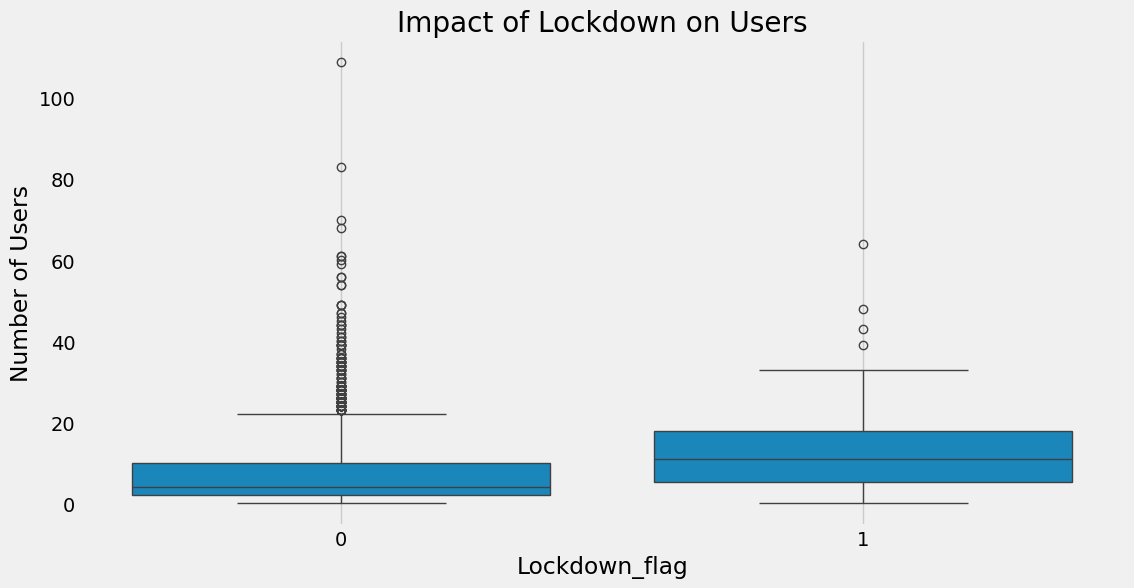

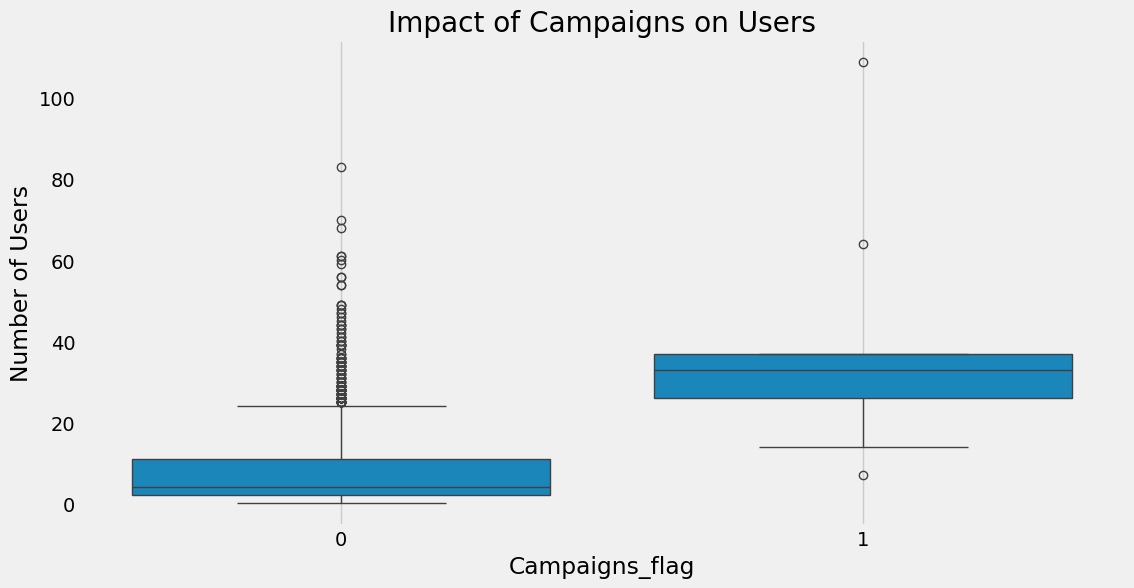

In [370]:
# Convert the columns to categorical type
df['Lockdown_flag'] = df['Lockdown_flag'].astype('category')
df['Campaigns_flag'] = df['Campaigns_flag'].astype('category')

# Create a boxplot to visualize the impact of Lockdown on Users
plt.figure(figsize=(12, 6))
sns.boxplot(x='Lockdown_flag', y='Users', data=df)
plt.title('Impact of Lockdown on Users')
plt.xlabel('Lockdown_flag')
plt.ylabel('Number of Users')
plt.grid()
plt.show()

# Create a boxplot to visualize the impact of Campaigns on Users
plt.figure(figsize=(12, 6))
sns.boxplot(x='Campaigns_flag', y='Users', data=df)
plt.title('Impact of Campaigns on Users')
plt.xlabel('Campaigns_flag')
plt.ylabel('Number of Users')
plt.grid()
plt.show()


## **Linear Regression** Solution

### 1. Data Preparation

In [371]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [372]:
df = pd.read_excel("Boston Scientific - Data Scientist - Task.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()
df.tail()

,Users,Lockdown_flag,Campaigns_flag
Date,,,
2021-05-27,16,0,0
2021-05-28,13,0,0
2021-05-29,6,0,0
2021-05-30,4,0,0
2021-05-31,1,0,0


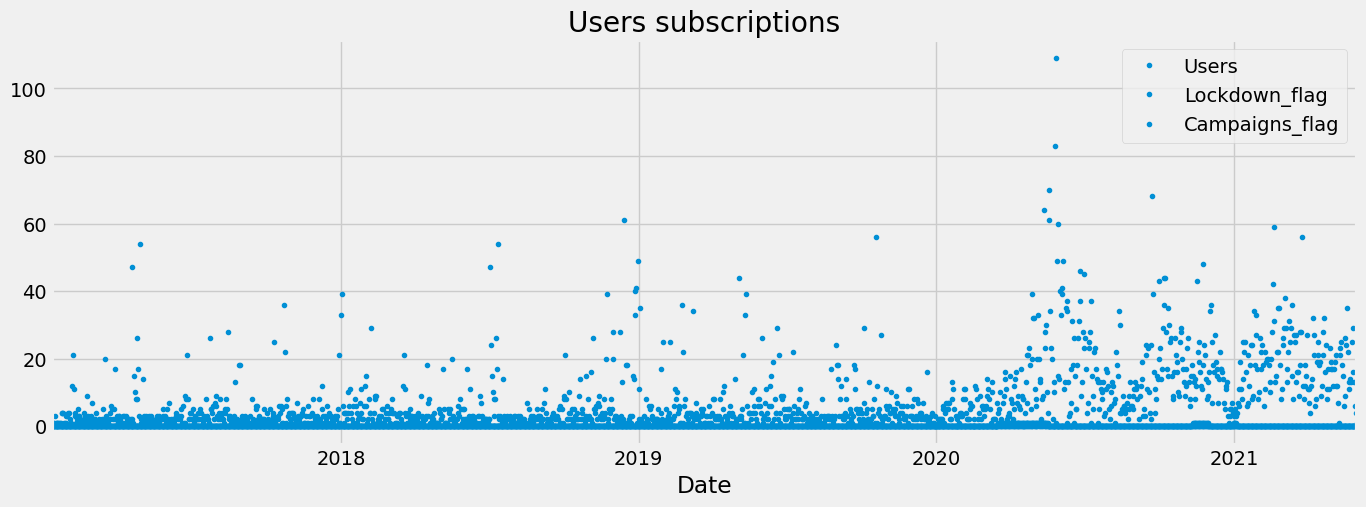

In [373]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Users subscriptions')
plt.show()

###2. Static Train/Test Split
Instead of this method we are gonna use ***Time Series Cross-Validation***

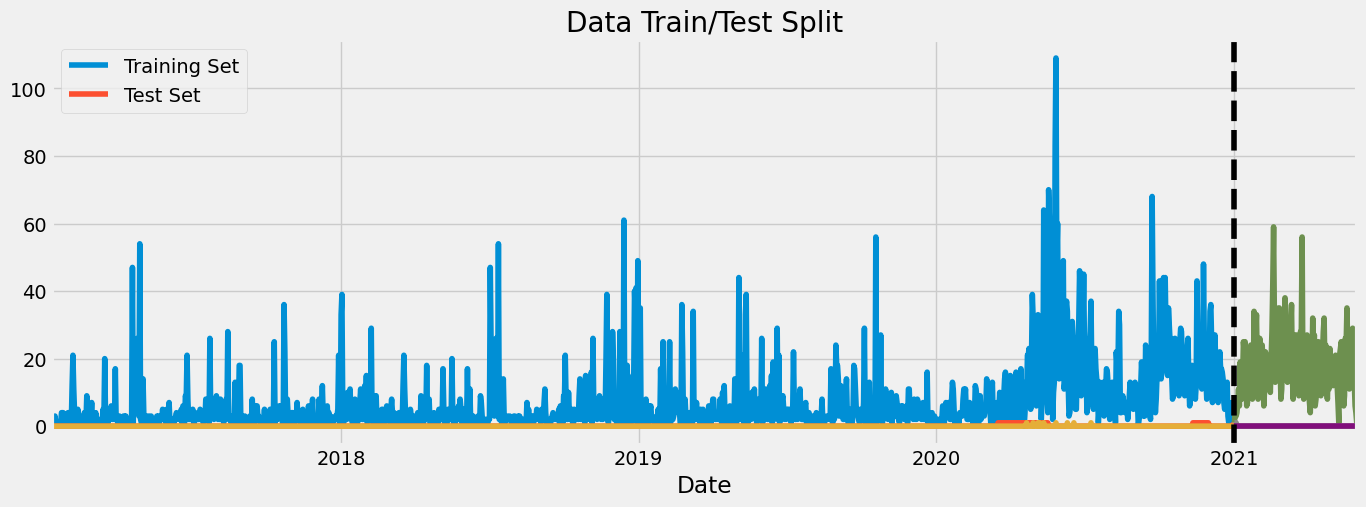

In [374]:
train = df.loc[df.index < '01-01-2021']
test = df.loc[df.index >= '01-01-2021']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### 3. Time Series Cross-Validation

In [375]:
tss = TimeSeriesSplit(n_splits=3, test_size=365*1, gap=1)
df = df.sort_index()

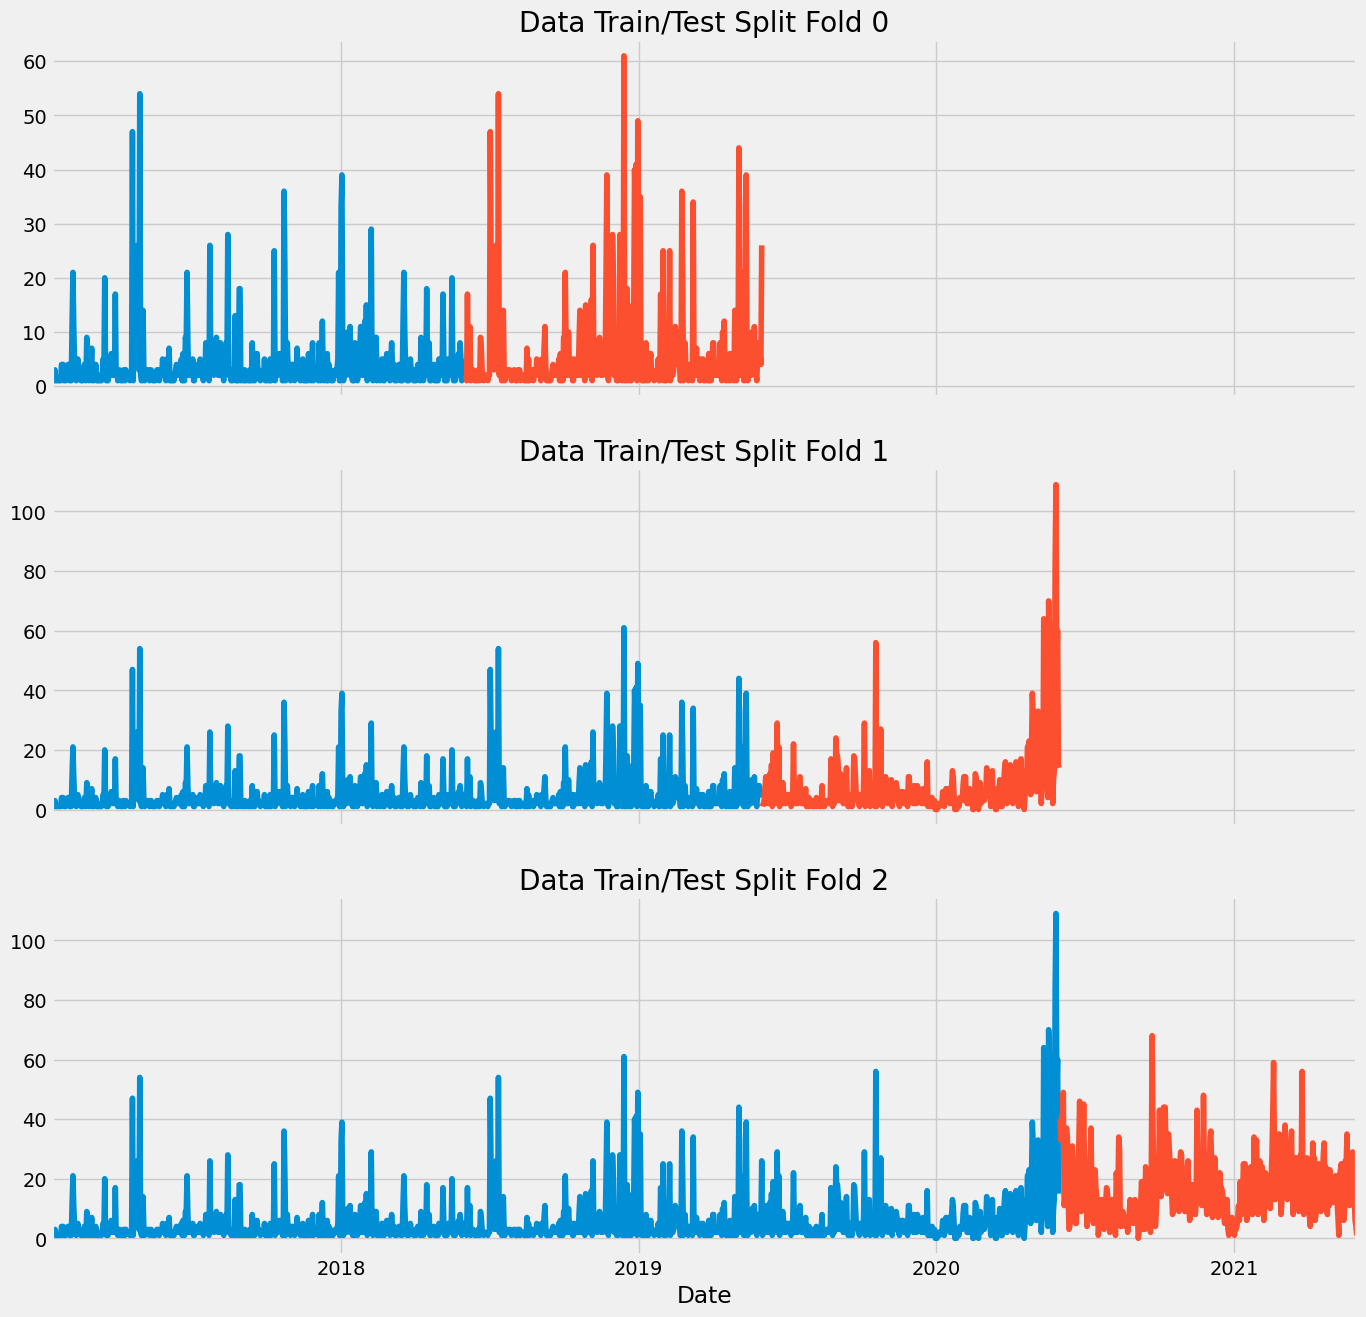

In [376]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Users'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Users'].plot(ax=axs[fold],
                         label='Test Set')
    fold += 1
plt.show()

### 4. Feature Engineering

In [377]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [378]:
def add_lags(df):
    target_map = df['Users'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [379]:
df = add_lags(df)

### 5. Correlation Analysis

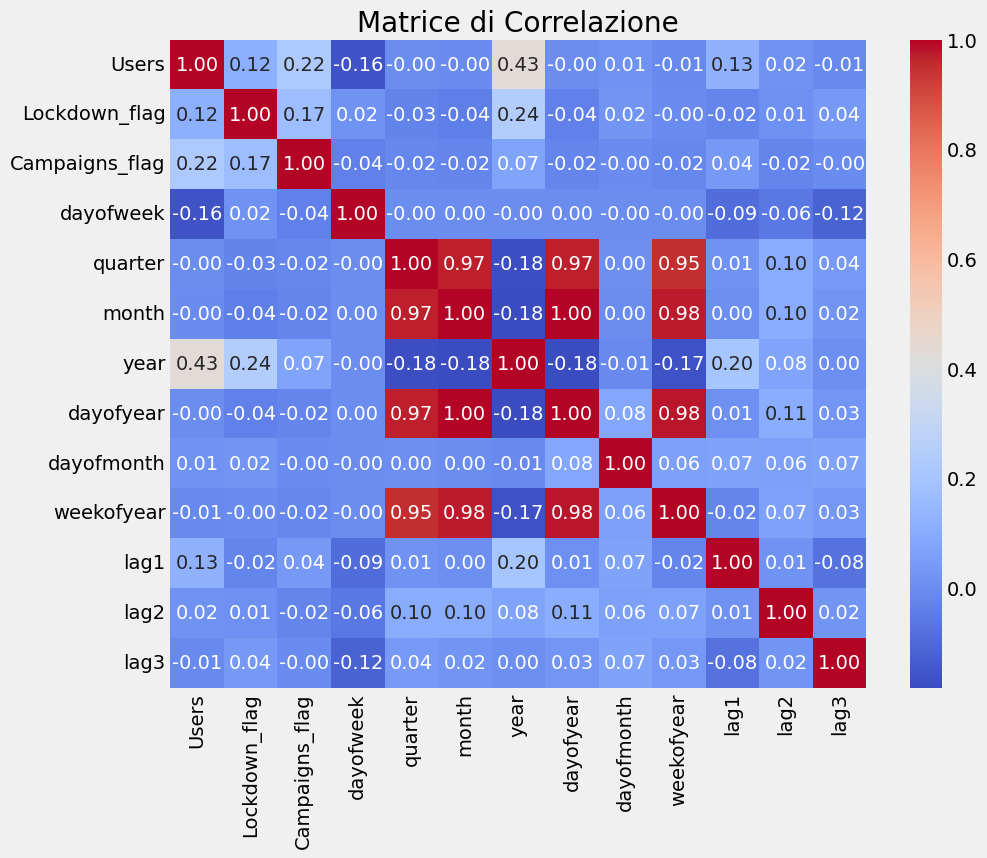

Correlazioni con 'Users':
                   Users
Users           1.000000
year            0.430527
Campaigns_flag  0.223549
lag1            0.126200
Lockdown_flag   0.116399
lag2            0.020208
dayofmonth      0.013736
dayofyear      -0.001698
quarter        -0.001732
month          -0.003846
weekofyear     -0.007258
lag3           -0.009317
dayofweek      -0.162745


In [380]:
correlation_matrix = df.corr()

users_correlation = correlation_matrix[['Users']].sort_values(by='Users', ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di Correlazione')
plt.show()

print("Correlazioni con 'Users':")
print(users_correlation)

###6. Handle Missing Values

In [381]:
df.head()

,Users,Lockdown_flag,Campaigns_flag,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Date,,,,,,,,,,,,,
2017-01-11,1,0,0,2,1,1,2017,11,11,2,NaN,NaN,NaN
2017-01-12,1,0,0,3,1,1,2017,12,12,2,NaN,NaN,NaN
2017-01-13,1,0,0,4,1,1,2017,13,13,2,NaN,NaN,NaN
2017-01-14,1,0,0,5,1,1,2017,14,14,2,NaN,NaN,NaN
2017-01-15,3,0,0,6,1,1,2017,15,15,2,NaN,NaN,NaN


In [382]:
df.tail()

,Users,Lockdown_flag,Campaigns_flag,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Date,,,,,,,,,,,,,
2021-05-27,16,0,0,3,2,5,2021,147,27,21,49.0,6.0,5.0
2021-05-28,13,0,0,4,2,5,2021,148,28,21,60.0,4.0,5.0
2021-05-29,6,0,0,5,2,5,2021,149,29,21,15.0,26.0,2.0
2021-05-30,4,0,0,6,2,5,2021,150,30,21,14.0,1.0,2.0
2021-05-31,1,0,0,0,2,5,2021,151,31,22,40.0,2.0,1.0


Dataset size:
(1602, 13)

Number of NaN values in the lag columns:
lag1     364
lag2     728
lag3    1092
dtype: int64

Percentage of NaN values in the lag columns:
lag1    22.721598
lag2    45.443196
lag3    68.164794
dtype: float64

Descriptive statistics for the lag columns:
              lag1        lag2        lag3
count  1238.000000  874.000000  510.000000
mean      5.721325    4.846682    4.098039
std       8.908175    7.264394    5.695809
min       0.000000    1.000000    1.000000
25%       2.000000    1.000000    1.000000
50%       3.000000    3.000000    2.000000
75%       6.000000    5.000000    4.000000
max     109.000000   61.000000   54.000000


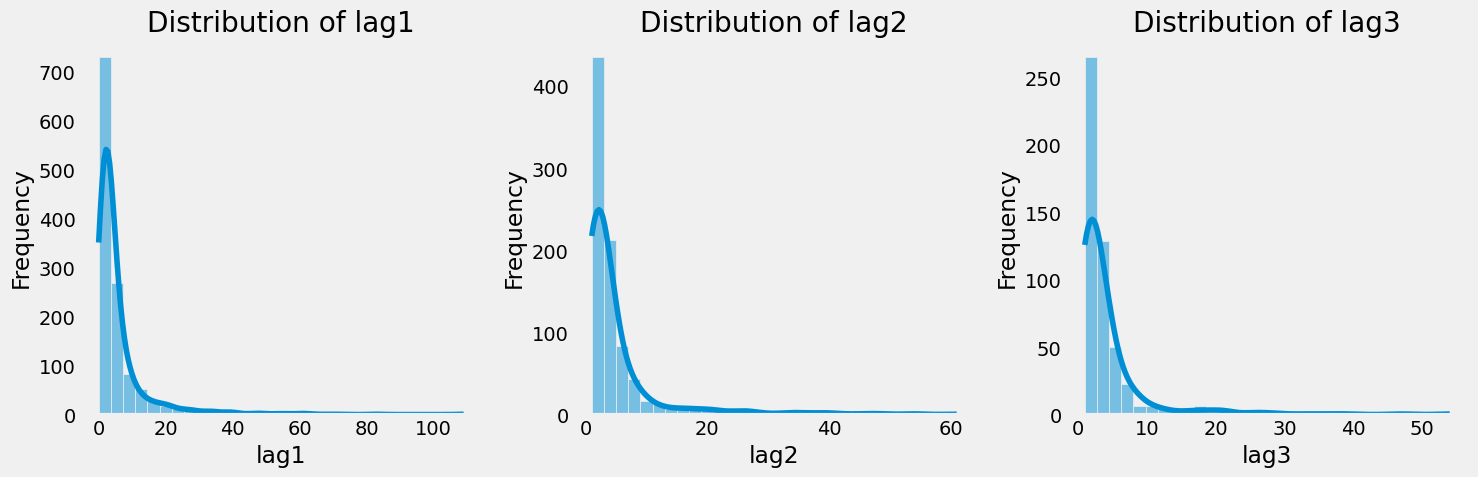

In [383]:
# Assuming your DataFrame is called 'df'
# Show the size of the dataset
print("Dataset size:")
print(df.shape)

# Show the number of NaN values in the lag columns
print("\nNumber of NaN values in the lag columns:")
print(df[['lag1', 'lag2', 'lag3']].isna().sum())

# Calculate the percentage of NaN values in the lag columns
percentage_nan = (df[['lag1', 'lag2', 'lag3']].isna().sum() / len(df)) * 100
print("\nPercentage of NaN values in the lag columns:")
print(percentage_nan)

# Descriptive statistics for the lag columns
print("\nDescriptive statistics for the lag columns:")
print(df[['lag1', 'lag2', 'lag3']].describe())

# Show the distribution of values in the lag columns
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

for i, col in enumerate(['lag1', 'lag2', 'lag3'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid()

plt.tight_layout()
plt.show()


In [384]:
# Imputation of NaN values with the mean without triggering warnings
df['lag1'] = df['lag1'].fillna(df['lag1'].mean())
df['lag2'] = df['lag2'].fillna(df['lag2'].mean())
df['lag3'] = df['lag3'].fillna(df['lag3'].mean())


In [385]:
# Check NaN
print("\nValori NaN dopo l'imputazione:")
print(df[['lag1', 'lag2', 'lag3']].isna().sum())


Valori NaN dopo l'imputazione:
lag1    0
lag2    0
lag3    0
dtype: int64


### 7. Model Training and Evaluation

In [386]:
# Make sure the DataFrame df is sorted by date
df = df.sort_index()

# Define the TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=3, test_size=365, gap=1)

fold = 0
preds = []
scores_rmse = []  # List to store RMSE scores
scores_mae = []   # List to store MAE scores
scores_rae = []   # List to store RAE scores

# Apply log transformation to the 'Users' column
df['Users'] = np.log(df['Users'] + 1)

# Loop through the train/test splits
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    # Create features for the training and testing sets
    train = create_features(train)
    test = create_features(test)

    # Define the features and target
    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3']
    TARGET = 'Users'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    # Initialize the linear regression model
    reg = LinearRegression()

    # Fit the model to the training data
    reg.fit(X_train, y_train)

    # Make predictions on the test set (in log space)
    y_pred_log = reg.predict(X_test)

    # Inverse the log transformation to get original scale predictions
    y_pred = np.exp(y_pred_log) - 1

    preds.append(y_pred)

    # Calculate RMSE
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores_rmse.append(rmse_score)

    # Calculate MAE
    mae_score = mean_absolute_error(y_test, y_pred)
    scores_mae.append(mae_score)

    # Calculate RAE
    rae_score = np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test - np.mean(y_test)))
    scores_rae.append(rae_score)

    print(f"Fold {fold}: RMSE = {rmse_score}, MAE = {mae_score}, RAE = {rae_score}")

    fold += 1

# Calculate and print the mean scores for each metric
linear_regression_mean_rmse = np.mean(scores_rmse)
linear_regression_mean_mae = np.mean(scores_mae)
linear_regression_mean_rae = np.mean(scores_rae)

Fold 0: RMSE = 2.249326838060454, MAE = 2.0885268476788355, RAE = 3.4180215413889323
Fold 1: RMSE = 2.699408870191439, MAE = 2.537619362715182, RAE = 3.7398347562149667
Fold 2: RMSE = 3.3115153461586346, MAE = 3.0983724967310087, RAE = 5.832312936216216


In [387]:
print(f"Mean RMSE over all folds: {linear_regression_mean_rmse}")
print(f"Mean MAE over all folds: {linear_regression_mean_mae}")
print(f"Mean RAE over all folds: {linear_regression_mean_rae}")

Mean RMSE over all folds: 2.7534170181368425
Mean MAE over all folds: 2.5748395690416754
Mean RAE over all folds: 4.330056411273372


### 8. Future Predictions
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [388]:
# Retrain on all data
df[TARGET] = np.log(df[TARGET] + 1)

# Create features for the entire DataFrame
df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3']
TARGET = 'Users'

X_all = df[FEATURES]
y_all = df[TARGET]

# Initialize the linear regression model
reg = LinearRegression()

# Train the model on all data
reg.fit(X_all, y_all)


LinearRegression()

In [389]:
df.index.max()

Timestamp('2021-05-31 00:00:00')

In [390]:
# Create future dataframe
future = pd.date_range('2021-05-31','2022-05-29')
print(future)

DatetimeIndex(['2021-05-31', '2021-06-01', '2021-06-02', '2021-06-03',
               '2021-06-04', '2021-06-05', '2021-06-06', '2021-06-07',
               '2021-06-08', '2021-06-09',
               ...
               '2022-05-20', '2022-05-21', '2022-05-22', '2022-05-23',
               '2022-05-24', '2022-05-25', '2022-05-26', '2022-05-27',
               '2022-05-28', '2022-05-29'],
              dtype='datetime64[ns]', length=364, freq='D')


In [391]:
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False

In [392]:
future_df.head()

,isFuture
2021-05-31,True
2021-06-01,True
2021-06-02,True
2021-06-03,True
2021-06-04,True


In [393]:
def fill_null_flags_with_zero(df):
    """
    Sets the 'Lockdown_flag' and 'Campaigns_flag' columns in the DataFrame
    to zero only if they contain null values.

    Parameters:
    df (pd.DataFrame): DataFrame containing the columns to modify.

    Returns:
    pd.DataFrame: Modified DataFrame with 'Lockdown_flag' and 'Campaigns_flag' set to zero where they were null.
    """
    # Check if the columns exist in the DataFrame
    if 'Lockdown_flag' in df.columns and 'Campaigns_flag' in df.columns:
        # Set null values to zero in the specified columns
        df['Lockdown_flag'] = df['Lockdown_flag'].fillna(0)
        df['Campaigns_flag'] = df['Campaigns_flag'].fillna(0)
    else:
        print("The columns 'Lockdown_flag' and 'Campaigns_flag' are not present in the DataFrame.")

    return df


In [394]:
# Concatenate df and future_df
df_and_future = pd.concat([df, future_df])

# Create features and add lags
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

# Fill null values with zero
df_and_future = fill_null_flags_with_zero(df_and_future)


In [395]:
# Chack NaN values
print(df_and_future.isnull().sum())

Users              364
Lockdown_flag        0
Campaigns_flag       0
dayofweek            0
quarter              0
month                0
year                 0
dayofyear            0
dayofmonth           0
weekofyear           0
lag1               364
lag2               728
lag3              1092
isFuture             0
dtype: int64


In [396]:
# Create a new df for future values
future_w_features = df_and_future.query('isFuture').copy()

In [397]:
future_w_features['pred_log'] = reg.predict(future_w_features[FEATURES])

In [398]:
future_w_features['pred'] = np.exp(future_w_features['pred_log']) - 1

In [399]:
future_w_features.tail(20)

,Users,Lockdown_flag,Campaigns_flag,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture,pred_log,pred
2022-05-10,NaN,0.0,0.0,1,2,5,2022,130,10,19,1.429846,1.643721,1.080418,True,1.442038,3.229307
2022-05-11,NaN,0.0,0.0,2,2,5,2022,131,11,19,1.448822,1.429846,0.526589,True,1.411206,3.100897
2022-05-12,NaN,0.0,0.0,3,2,5,2022,132,12,19,1.372307,1.474144,0.959135,True,1.380502,2.976897
2022-05-13,NaN,0.0,0.0,4,2,5,2022,133,13,19,1.327761,1.489299,0.959135,True,1.349616,2.855944
2022-05-14,NaN,0.0,0.0,5,2,5,2022,134,14,19,1.080418,1.223156,0.959135,True,1.319014,2.739733
2022-05-15,NaN,0.0,0.0,6,2,5,2022,135,15,19,1.194706,0.959135,0.741276,True,1.288497,2.627332
2022-05-16,NaN,0.0,0.0,0,2,5,2022,136,16,20,1.457646,1.660640,1.223156,True,1.475012,3.371090
2022-05-17,NaN,0.0,0.0,1,2,5,2022,137,17,20,1.439569,1.634547,0.959135,True,1.444052,3.237835
2022-05-18,NaN,0.0,0.0,2,2,5,2022,138,18,20,1.522467,1.516302,1.080418,True,1.413499,3.110313
2022-05-19,NaN,0.0,0.0,3,2,5,2022,139,19,20,1.419607,1.429846,1.248441,True,1.382819,2.986122


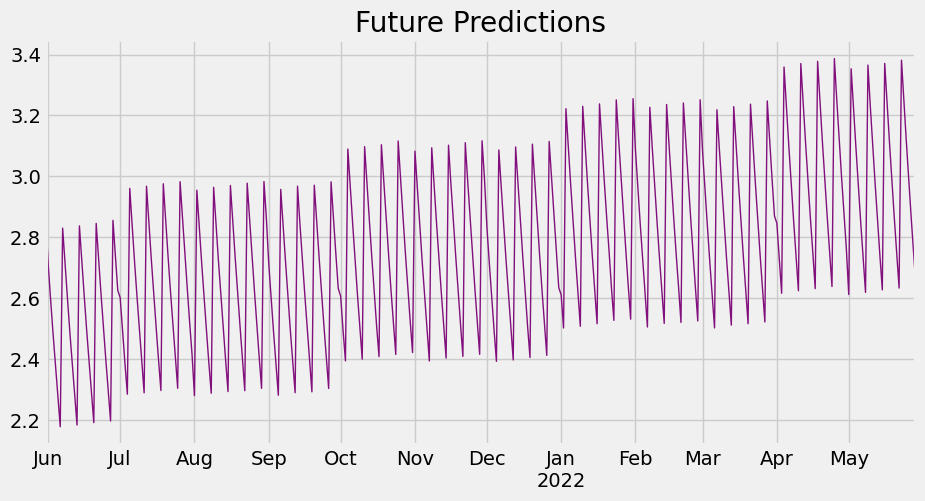

In [400]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[5],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

### 9. Model Persistence

In [401]:
# Save model using joblib
joblib.dump(reg, 'regressor_basic_model.joblib')


['regressor_basic_model.joblib']

### 10. Visualization of Predictions

In [402]:
# load model
reg_new = joblib.load('regressor_basic_model.joblib')

# make predictions
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])

In [403]:
# Recalculate predictions for the new model
future_w_features['pred_log'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'] = np.exp(future_w_features['pred_log']) - 1  # Inverse of the logarithmic transformation


<Axes: title={'center': 'Future Predictions'}>

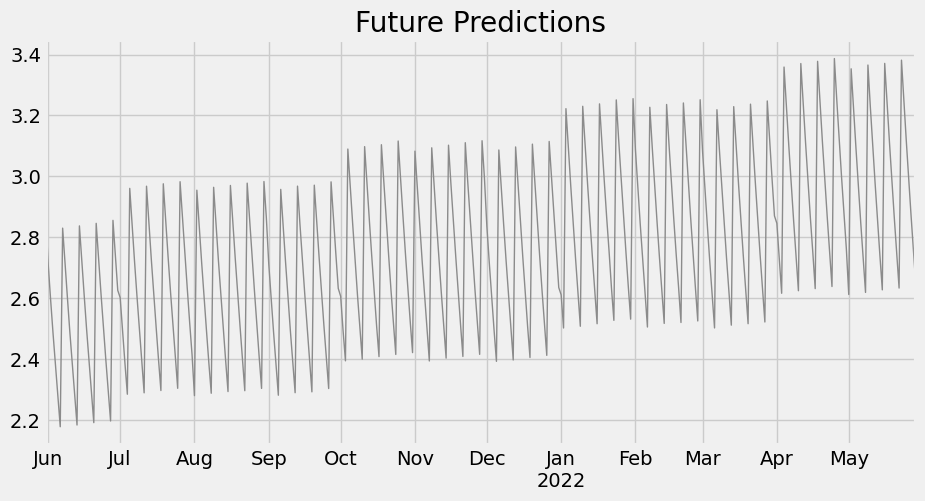

In [404]:
# Graph for predictions
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')


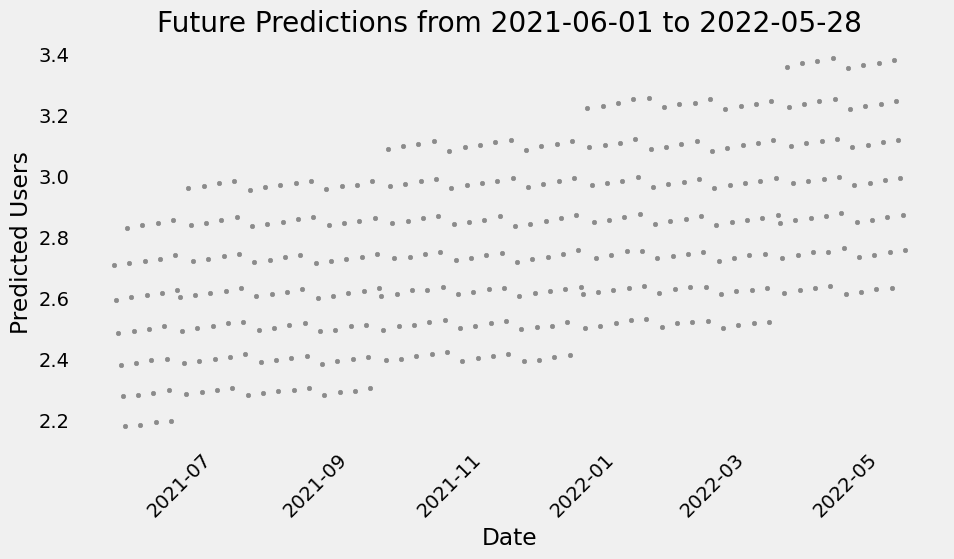

In [405]:
# Assume you want to plot the predictions for a specific time range
start_date = '2021-06-01'  # Start date
end_date = '2022-05-28'    # End date

# Filter the DataFrame for the specified date range
filtered_predictions = future_w_features.loc[start_date:end_date]

# Create a scatter plot of the predictions
plt.figure(figsize=(10, 5))
plt.scatter(filtered_predictions.index, filtered_predictions['pred'], color=color_pal[4], s=10)  # s is the size of the points
plt.title('Future Predictions from {} to {}'.format(start_date, end_date))
plt.xlabel('Date')
plt.ylabel('Predicted Users')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.grid()  # Add a grid for easier reading
plt.show()


## **XGBoost** model

###1. Data Preparation

In [406]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

df = pd.read_excel("Boston Scientific - Data Scientist - Task.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()
df.tail()

,Users,Lockdown_flag,Campaigns_flag
Date,,,
2021-05-27,16,0,0
2021-05-28,13,0,0
2021-05-29,6,0,0
2021-05-30,4,0,0
2021-05-31,1,0,0


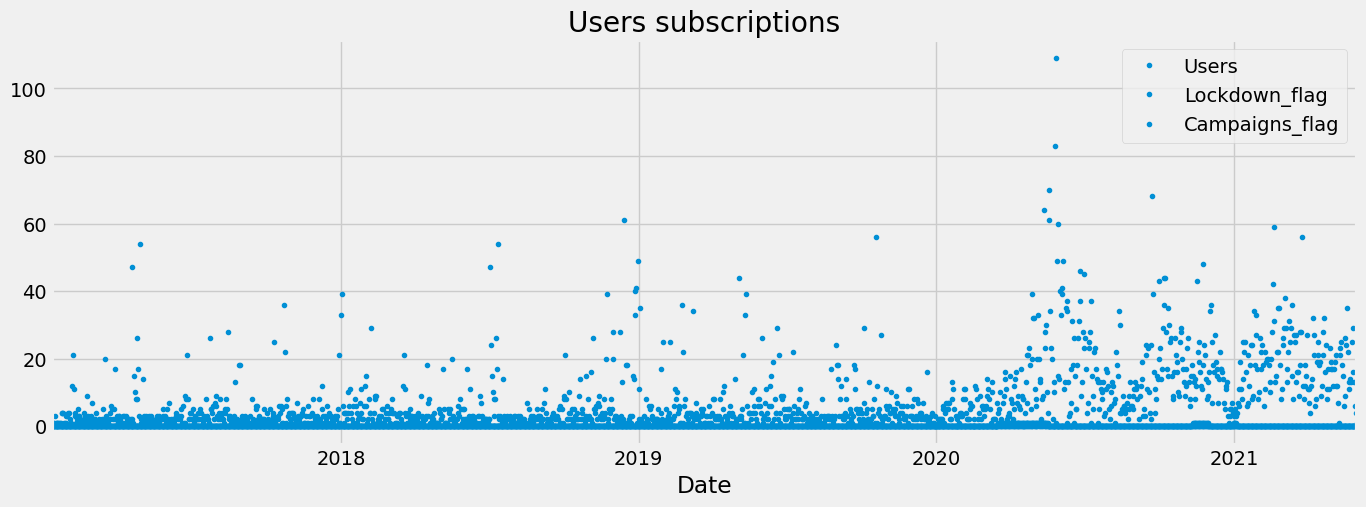

In [407]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Users subscriptions')
plt.show()

### 2. Train / Test Split

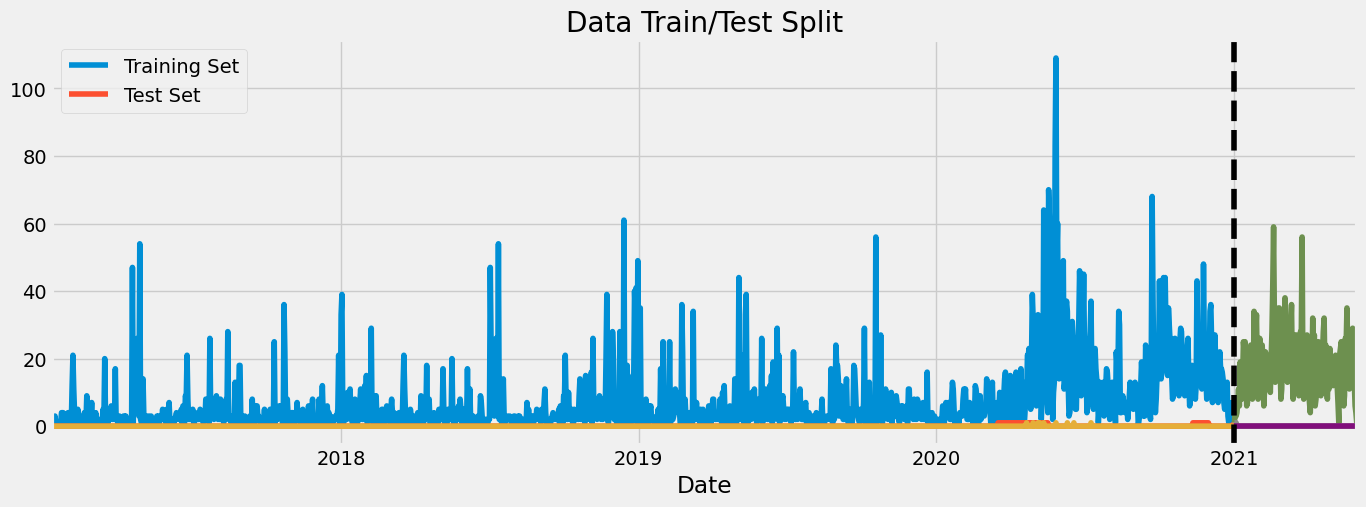

In [408]:
train = df.loc[df.index < '01-01-2021']
test = df.loc[df.index >= '01-01-2021']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


### 3. Time Series Cross Validation

In [409]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=365*1, gap=1)
df = df.sort_index()

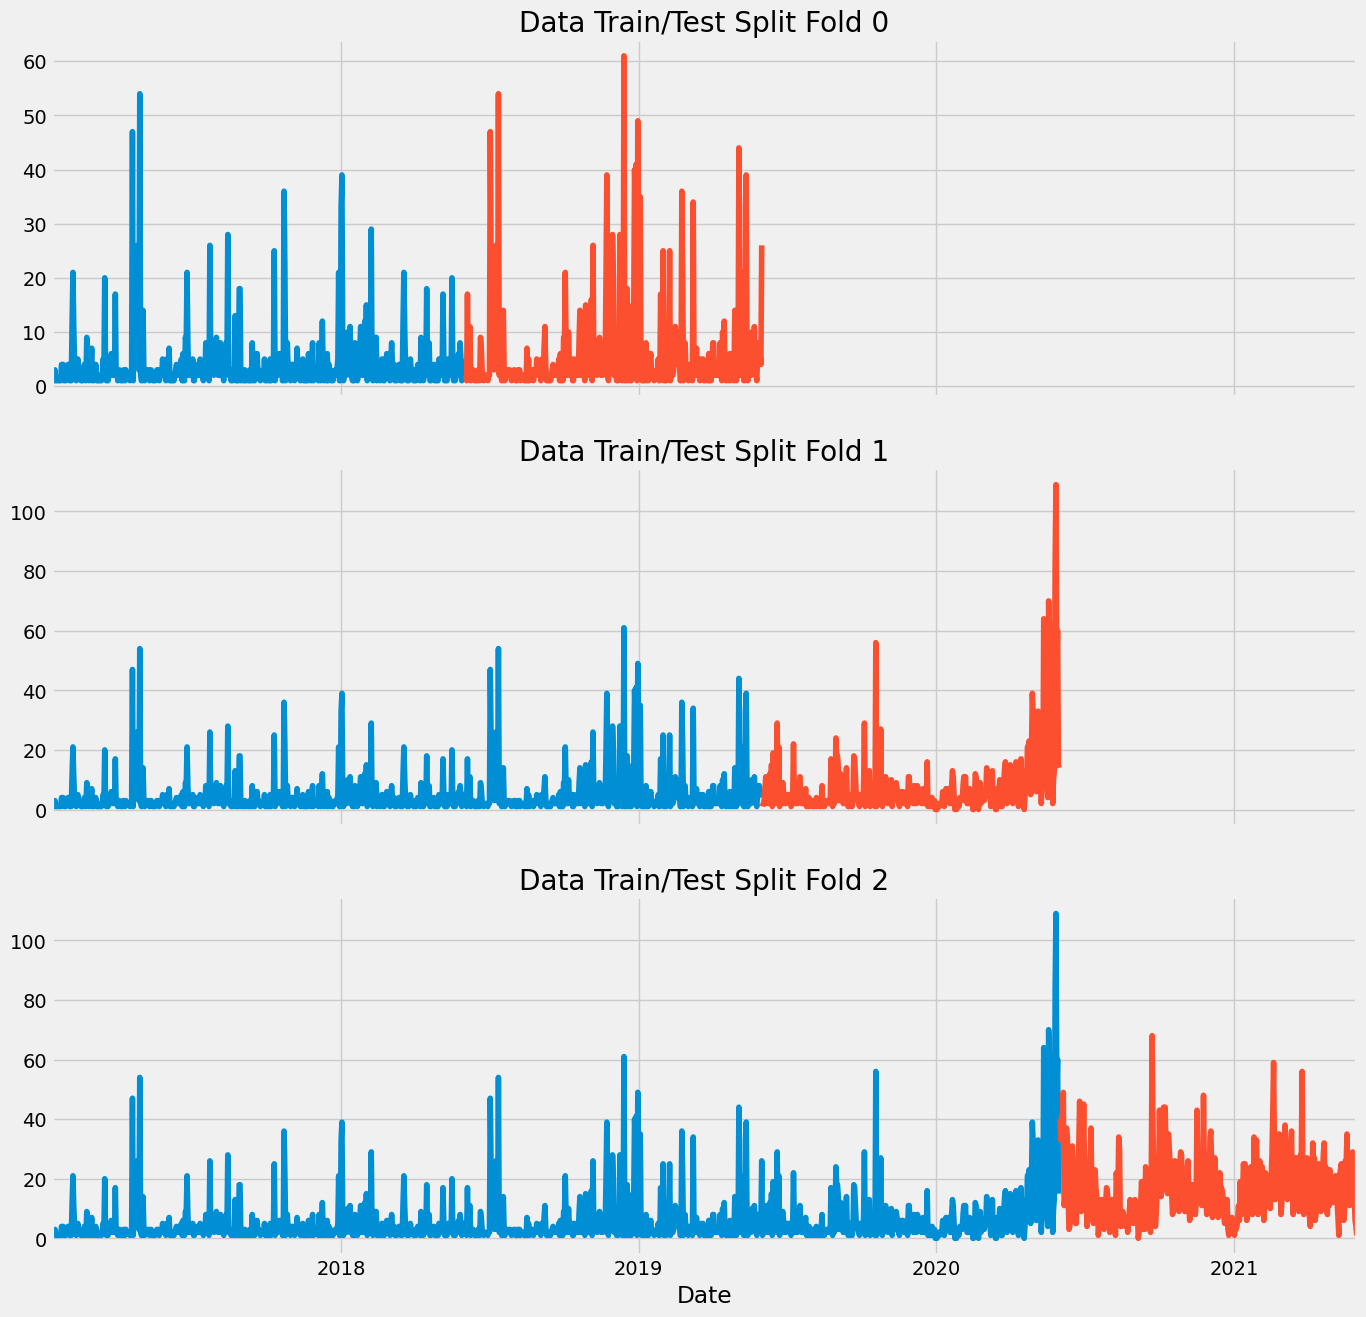

In [410]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Users'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Users'].plot(ax=axs[fold],
                         label='Test Set')
    fold += 1
plt.show()

### 4. Feature Engineering
The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).
Having the lag_1(1 year) feature effectively constrains your forecasting ability because it creates a dependency on historical data that you won't have access to when predicting future values beyond one year. This limits the model's scope and prevents it from generating valid predictions for future periods where the necessary lagged data is unavailable. To forecast beyond one year, you should consider removing or modifying lagged features so the model can rely on other predictors or methods that do not require unavailable future values.

In [411]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [412]:
def add_lags(df):
    target_map = df['Users'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [413]:
df = add_lags(df)

### 5. Correlation Analysis

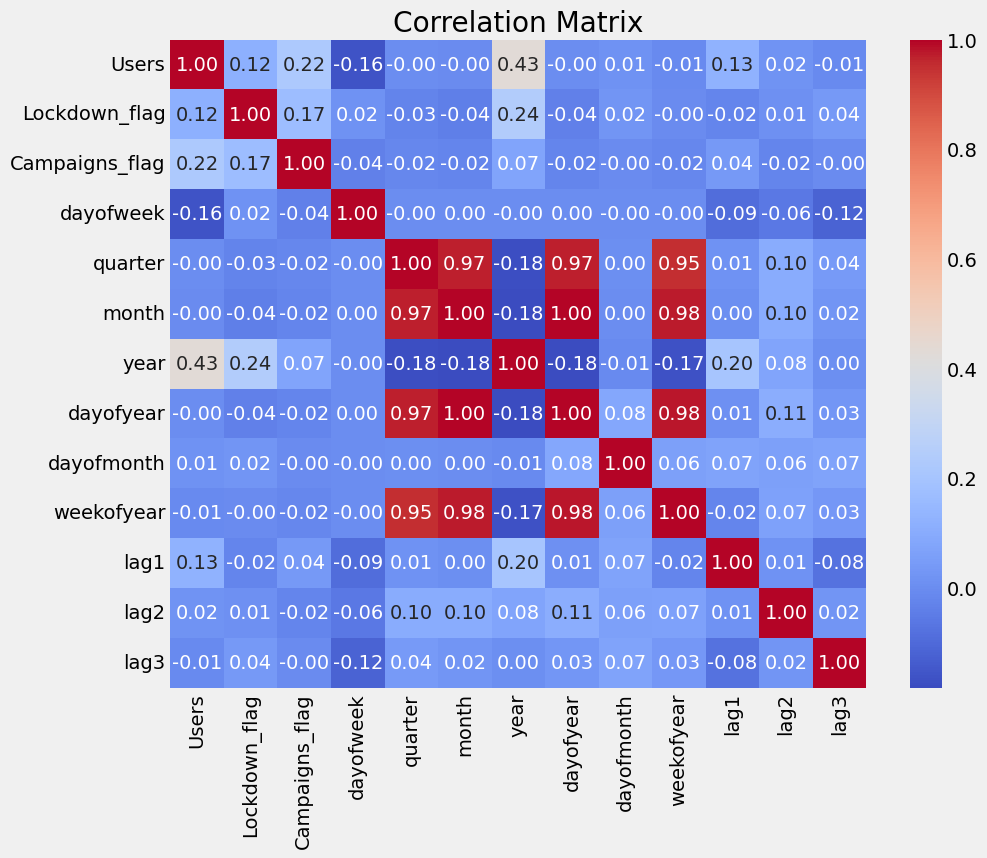

Correlations with 'Users':
                   Users
Users           1.000000
year            0.430527
Campaigns_flag  0.223549
lag1            0.126200
Lockdown_flag   0.116399
lag2            0.020208
dayofmonth      0.013736
dayofyear      -0.001698
quarter        -0.001732
month          -0.003846
weekofyear     -0.007258
lag3           -0.009317
dayofweek      -0.162745


In [414]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Select the correlation with the 'Users' column
users_correlation = correlation_matrix[['Users']].sort_values(by='Users', ascending=False)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Display correlations with 'Users'
print("Correlations with 'Users':")
print(users_correlation)

### 6. Model Training and Evaluation

In [415]:
df = df.sort_index()

fold = 0
preds = []
rmse_scores = []
mae_scores = []
rae_scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3']
    TARGET = 'Users'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    # Define XGBoost model
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000, early_stopping_rounds=50,
                           objective='reg:squarederror', max_depth=3,
                           learning_rate=0.01)

    # Training
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    # Predictions on test
    y_pred = reg.predict(X_test)
    preds.append(y_pred)

    # RMSE Fold
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse_score)

    # MAE Fold
    mae_score = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae_score)

    # RAE Fold
    rae_score = np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test - np.mean(y_test)))
    rae_scores.append(rae_score)

    print(f"Fold {fold}: RMSE = {rmse_score}, MAE = {mae_score}, RAE = {rae_score}")
    fold += 1

# Calculate mean scores for each metric
rmse_score_xgboost_mean = np.mean(rmse_scores)
mae_score_xgboost_mean = np.mean(mae_scores)  # Corrected to mae_scores
rae_score_xgboost_mean = np.mean(rae_scores)  # Corrected to rae_scores

[0]	validation_0-rmse:6.73171	validation_1-rmse:10.38086
[100]	validation_0-rmse:5.52587	validation_1-rmse:9.51245
[200]	validation_0-rmse:5.22536	validation_1-rmse:9.35751
[274]	validation_0-rmse:5.13641	validation_1-rmse:9.36526
Fold 0: RMSE = 9.355749654704749, MAE = 4.513507935772203, RAE = 0.8436626185470885
[0]	validation_0-rmse:8.40234	validation_1-rmse:13.60289
[100]	validation_0-rmse:6.89932	validation_1-rmse:12.52101
[200]	validation_0-rmse:6.50225	validation_1-rmse:12.43044
[242]	validation_0-rmse:6.41121	validation_1-rmse:12.44779
Fold 1: RMSE = 12.42456365462168, MAE = 6.110220431954893, RAE = 0.9382164458153044
[0]	validation_0-rmse:10.21406	validation_1-rmse:19.65122
[100]	validation_0-rmse:7.65802	validation_1-rmse:12.92572
[177]	validation_0-rmse:7.04251	validation_1-rmse:12.97217
Fold 2: RMSE = 12.710777981166654, MAE = 9.651451929301432, RAE = 1.1449921043652957


###7. Evaluation notice
Now we can notice 3 different scores for the 3 different folds that we created, so it's like running 3 diferent experiments

In [416]:
# Print mean scores
print(f"Mean RMSE over all folds: {rmse_score_xgboost_mean}")
print(f"Mean MAE over all folds: {mae_score_xgboost_mean}")
print(f"Mean RAE over all folds: {rae_score_xgboost_mean}")


Mean RMSE over all folds: 11.497030430164363
Mean MAE over all folds: 6.758393432342842
Mean RAE over all folds: 0.9756237229092295


### 8. Future Predictions
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation


In [417]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'Users'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=250,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:13.01459


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:28:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:9.11043
[200]	validation_0-rmse:8.12292
[249]	validation_0-rmse:7.93658


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [418]:
df.index.max()

Timestamp('2021-05-31 00:00:00')

In [419]:
# Create future dataframe
future = pd.date_range('2021-05-31','2022-05-29')
print(future)

DatetimeIndex(['2021-05-31', '2021-06-01', '2021-06-02', '2021-06-03',
               '2021-06-04', '2021-06-05', '2021-06-06', '2021-06-07',
               '2021-06-08', '2021-06-09',
               ...
               '2022-05-20', '2022-05-21', '2022-05-22', '2022-05-23',
               '2022-05-24', '2022-05-25', '2022-05-26', '2022-05-27',
               '2022-05-28', '2022-05-29'],
              dtype='datetime64[ns]', length=364, freq='D')


In [420]:
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False

In [421]:
future_df.head()

,isFuture
2021-05-31,True
2021-06-01,True
2021-06-02,True
2021-06-03,True
2021-06-04,True


In [422]:
def fill_null_flags_with_zero(df):
    """
    Sets the 'Lockdown_flag' and 'Campaigns_flag' columns in the DataFrame
    to zero only if they contain null values.

    Parameters:
    df (pd.DataFrame): DataFrame containing the columns to modify.

    Returns:
    pd.DataFrame: Modified DataFrame with 'Lockdown_flag' and 'Campaigns_flag'
    set to zero where they were null.
    """
    # Check if the columns exist in the DataFrame
    if 'Lockdown_flag' in df.columns and 'Campaigns_flag' in df.columns:
        # Set only the null values in the specified columns to zero
        df['Lockdown_flag'] = df['Lockdown_flag'].fillna(0)
        df['Campaigns_flag'] = df['Campaigns_flag'].fillna(0)
    else:
        print("The columns 'Lockdown_flag' and 'Campaigns_flag' are not present in the DataFrame.")

    return df


In [423]:
# Concatenate df and future_df
df_and_future = pd.concat([df, future_df])

# Create features and add lags
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

# Fill null values with zero
df_and_future = fill_null_flags_with_zero(df_and_future)

In [424]:
# Check the number of null values
print(df_and_future.isnull().sum())

Users              364
Lockdown_flag        0
Campaigns_flag       0
dayofweek            0
quarter              0
month                0
year                 0
dayofyear            0
dayofmonth           0
weekofyear           0
lag1               364
lag2               728
lag3              1092
isFuture             0
dtype: int64


In [425]:
# Create a new DataFrame with future rows
future_w_features = df_and_future.query('isFuture').copy()

In [426]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [427]:
future_w_features.tail(20)

,Users,Lockdown_flag,Campaigns_flag,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture,pred
2022-05-10,NaN,0.0,0.0,1,2,5,2022,130,10,19,23.0,64.0,6.0,True,20.437563
2022-05-11,NaN,0.0,0.0,2,2,5,2022,131,11,19,25.0,23.0,1.0,True,20.437563
2022-05-12,NaN,0.0,0.0,3,2,5,2022,132,12,19,18.0,28.0,4.0,True,20.437563
2022-05-13,NaN,0.0,0.0,4,2,5,2022,133,13,19,15.0,30.0,4.0,True,16.233791
2022-05-14,NaN,0.0,0.0,5,2,5,2022,134,14,19,6.0,10.0,4.0,True,8.996875
2022-05-15,NaN,0.0,0.0,6,2,5,2022,135,15,19,9.0,4.0,2.0,True,8.996875
2022-05-16,NaN,0.0,0.0,0,2,5,2022,136,16,20,26.0,70.0,10.0,True,20.946785
2022-05-17,NaN,0.0,0.0,1,2,5,2022,137,17,20,24.0,61.0,4.0,True,21.325541
2022-05-18,NaN,0.0,0.0,2,2,5,2022,138,18,20,35.0,34.0,6.0,True,21.325541
2022-05-19,NaN,0.0,0.0,3,2,5,2022,139,19,20,22.0,23.0,11.0,True,21.125210


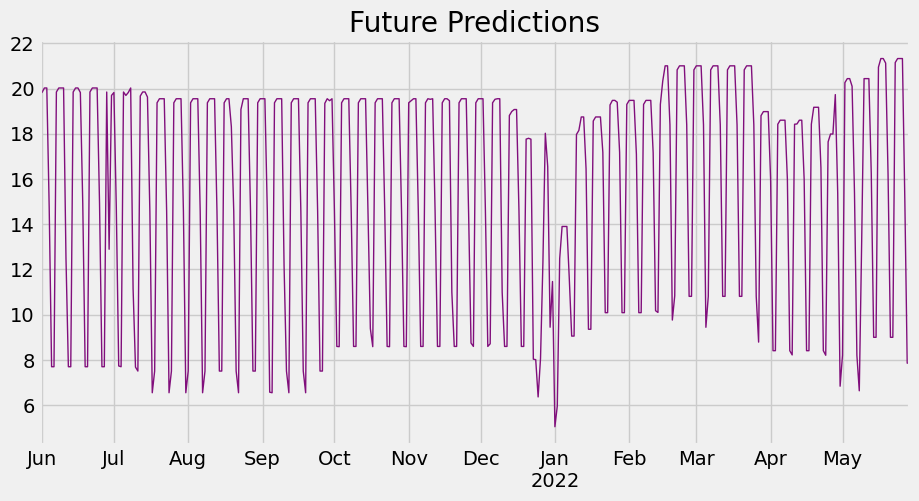

In [428]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[5],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

### 9. Model Persistence

In [429]:
# Save model
reg.save_model('XGBregressor_basic_model.json')

###10. Visualization of Predictions

<Axes: title={'center': 'Future Predictions'}>

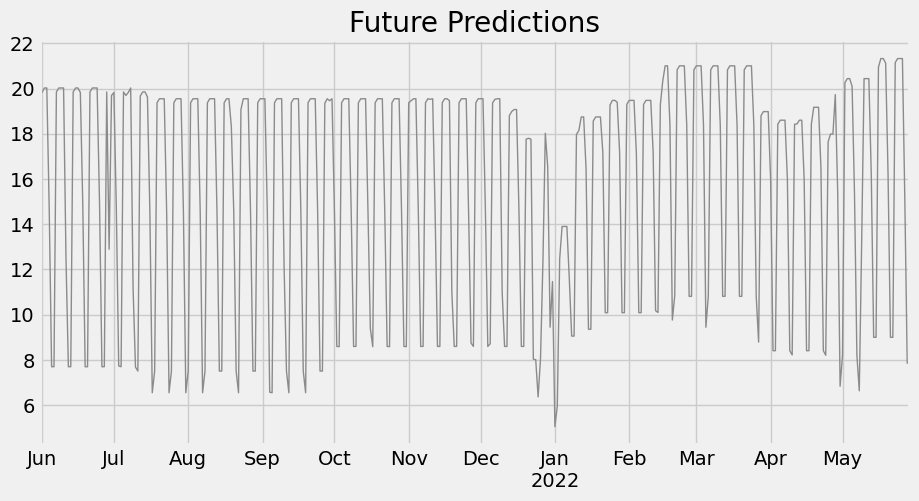

In [430]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('XGBregressor_basic_model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

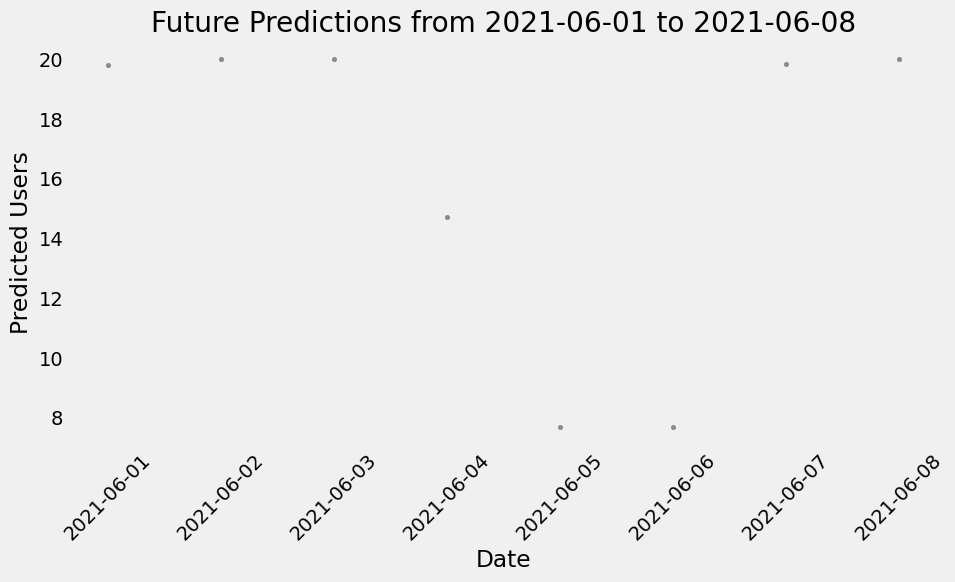

In [431]:
# Supponiamo che tu voglia plottare le previsioni per un intervallo di tempo specifico
start_date = '2021-06-01'  # Data di inizio
end_date = '2021-06-08'    # Data di fine

# Filtra il DataFrame per l'intervallo di date specificato
filtered_predictions = future_w_features.loc[start_date:end_date]

# Crea uno scatter plot delle previsioni
plt.figure(figsize=(10, 5))
plt.scatter(filtered_predictions.index, filtered_predictions['pred'], color=color_pal[4], s=10)  # s è la dimensione dei punti
plt.title('Future Predictions from {} to {}'.format(start_date, end_date))
plt.xlabel('Date')
plt.ylabel('Predicted Users')
plt.xticks(rotation=45)  # Ruota le etichette delle date per una migliore leggibilità
plt.grid()  # Aggiungi una griglia per facilitare la lettura
plt.show()

## **Prophet** Solution

###1. Data Preparation

In [432]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [433]:
df = pd.read_excel("Boston Scientific - Data Scientist - Task.xlsx")

# Data Processing
df['Date'] = pd.to_datetime(df['Date'])
df.rename(columns={'Date': 'ds', 'Users': 'y'}, inplace=True)
df['unique_id'] = 1
df.head()

,ds,y,Lockdown_flag,Campaigns_flag,unique_id
0,2017-01-11,1,0,0,1
1,2017-01-12,1,0,0,1
2,2017-01-13,1,0,0,1
3,2017-01-14,1,0,0,1
4,2017-01-15,3,0,0,1


###2. Feature Engineering

In [434]:
# Select only the necessary columns
df = df[['unique_id', 'ds', 'y']]  # Create a DataFrame with the required columns

# Ensure the 'ds' column is sorted
df = df.sort_values(by='ds')

# Save the original y values
original_y = df['y'].copy()

# Transform the data: apply logarithm to y values (adding 1 to avoid log(0))
df['y'] = np.log1p(df['y'])  # Use log1p to handle cases where y = 0


###3. Model Training  

In [435]:
# Initialize and fit the Prophet model
model = Prophet()
model.fit(df[['ds', 'y']])  # Use the logarithmic data for training

# Create a DataFrame for future predictions
future = model.make_future_dataframe(periods=730)  # Forecast for two years ahead


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjjcfht75/gimlitgh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjjcfht75/qimadz_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84694', 'data', 'file=/tmp/tmpjjcfht75/gimlitgh.json', 'init=/tmp/tmpjjcfht75/qimadz_0.json', 'output', 'file=/tmp/tmpjjcfht75/prophet_modelquoxiw02/prophet_model-20241010162812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:28:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:28:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


###4. Future Predictions

In [436]:
# Make predictions
forecast = model.predict(future)


In [437]:
# Invert the logarithmic transformation to get the original predictions
forecast['yhat'] = np.expm1(forecast['yhat'])  # Use expm1 to revert to the original values
forecast['yhat_lower'] = np.expm1(forecast['yhat_lower'])
forecast['yhat_upper'] = np.expm1(forecast['yhat_upper'])

# Display the first few rows of the predictions
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2017-01-11,2.248860,0.316132,6.944197
1,2017-01-12,2.331896,0.453085,7.263721
2,2017-01-13,1.779606,0.164066,5.697757
3,2017-01-14,1.141468,-0.053957,4.490330
4,2017-01-15,1.172309,-0.086635,3.929312


In [438]:
# Force yhat values to be >= 0 (if necessary)
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

In [439]:
# Restore the original y values for display
df['y'] = original_y

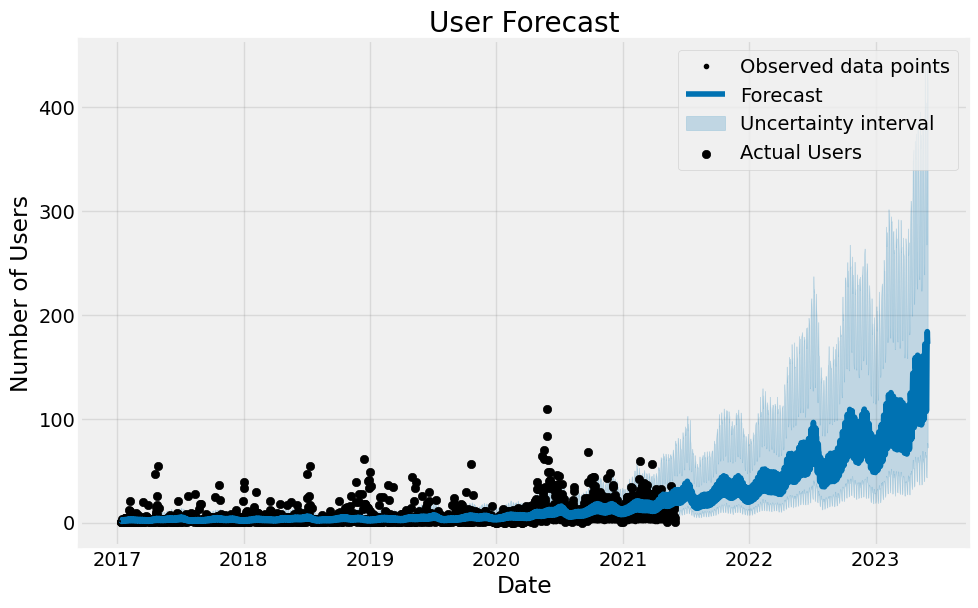

In [440]:
# Visualize the results
fig = model.plot(forecast)
plt.title('User Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.scatter(df['ds'], df['y'], color='black', label='Actual Users')
plt.legend()
plt.show()


In [441]:
# Ensure the 'ds' columns of df and forecast are aligned
merged_df = pd.merge(df[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# Ensure the 'ds' column is in datetime format
merged_df['ds'] = pd.to_datetime(merged_df['ds'])

# Set 'ds' as the index of the DataFrame
merged_df.set_index('ds', inplace=True)

# Display the first few rows of the new DataFrame
merged_df.head()


,y,yhat
ds,,
2017-01-11,1,2.248860
2017-01-12,1,2.331896
2017-01-13,1,1.779606
2017-01-14,1,1.141468
2017-01-15,3,1.172309


###5. Model Evaluation

In [442]:
# Calculate MAE
prophet_mae = mean_absolute_error(merged_df['y'], merged_df['yhat'])
print(f'Prophet MAE: {prophet_mae:.4f}')  # Print MAE value

# Calculate RMSE
prophet_mse = mean_squared_error(merged_df['y'], merged_df['yhat'])
prophet_rmse = np.sqrt(prophet_mse)  # Take the square root of MSE to get RMSE
print(f'Prophet RMSE: {prophet_rmse:.4f}')  # Print RMSE value

# Calculate RAE (using MAE for the example)
prophet_rae = np.sqrt(prophet_mae)  # This will give the root of the absolute error
print(f'Prophet RAE: {prophet_rae:.4f}')  # Print RAE value


Prophet MAE: 4.5432
Prophet RMSE: 8.9726
Prophet RAE: 2.1315


In [443]:
def plot_user_forecast(merged_df, forecast, start_date, end_date):
    """
    Plot the actual and predicted users in the specified date range.

    Parameters:
    - merged_df: DataFrame with actual user data.
    - forecast: DataFrame with predicted user data.
    - start_date: Start date (string in 'day-month-year' format).
    - end_date: End date (string in 'day-month-year' format).
    """

    # Convert start and end dates to datetime format
    start_date = pd.to_datetime(start_date, format='%d-%m-%Y')
    end_date = pd.to_datetime(end_date, format='%d-%m-%Y')

    # Filter the dataframes by the specified date range
    filtered_merged_df = merged_df[(merged_df.index >= start_date) & (merged_df.index <= end_date)]
    filtered_forecast = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

    # Create a scatter plot of actual and predicted users
    plt.figure(figsize=(10, 5))

    # Scatter plot for actual users
    plt.scatter(filtered_merged_df.index, filtered_merged_df['y'], color='blue', s=10, label='Actual Users')

    # Scatter plot for predicted users
    plt.scatter(filtered_forecast['ds'], filtered_forecast['yhat'], color='red', s=10, label='Predicted Users')

    # Add title and labels
    plt.title(f'User Forecast from {start_date.date()} to {end_date.date()}', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Users')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add grid and legend
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


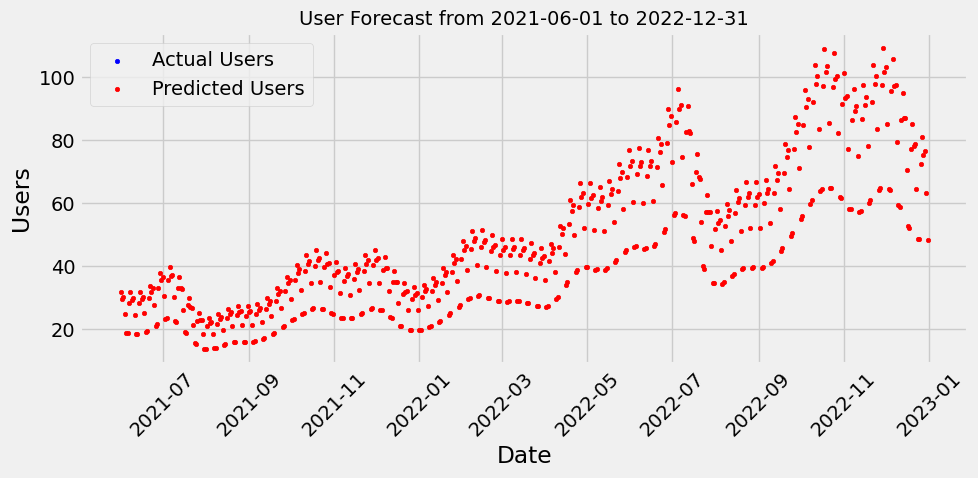

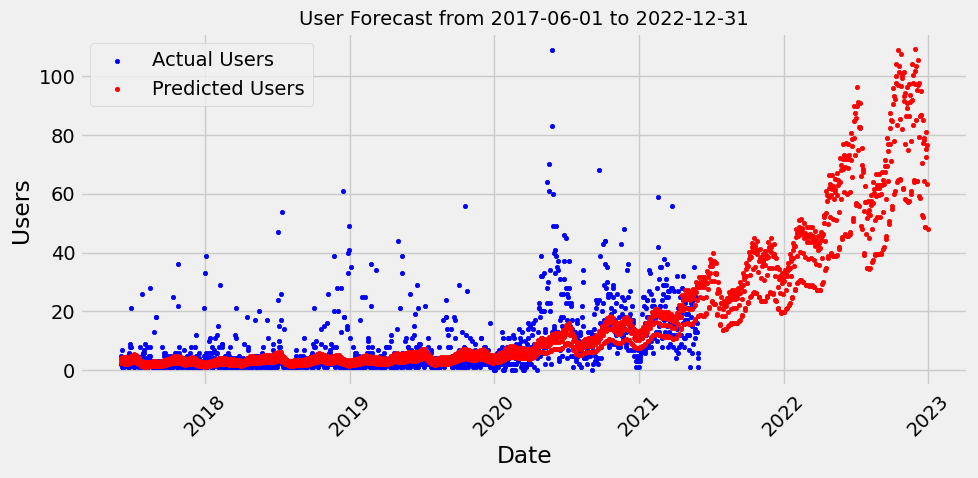

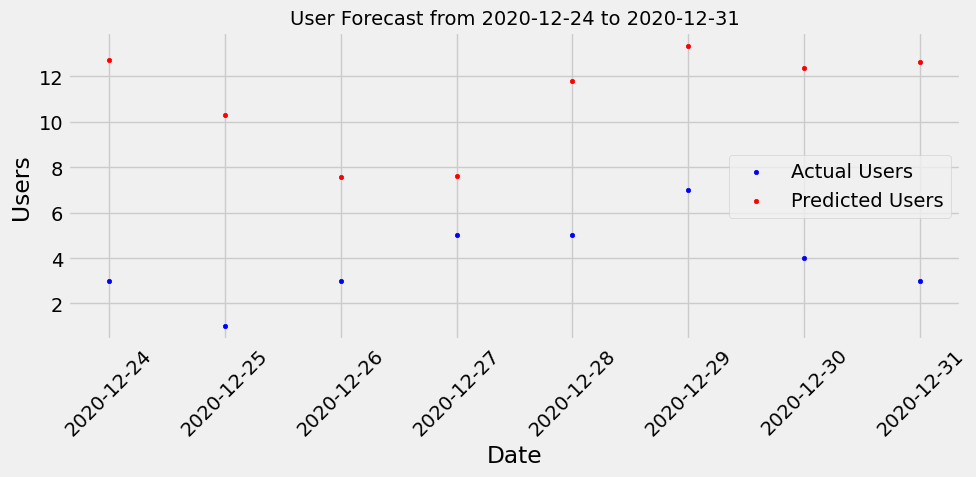

In [444]:
# Example usage of the function
plot_user_forecast(merged_df, forecast, '01-06-2021', '31-12-2022')  # From June 1, 2021 to December 31, 2022
plot_user_forecast(merged_df, forecast, '01-06-2017', '31-12-2022')  # From June 1, 2017 to December 31, 2022
plot_user_forecast(merged_df, forecast, '24-12-2020', '31-12-2020')  # From December 24, 2020 to December 31, 2020


### 6. Model Persistence

In [445]:
import pickle

# Save Prophet model
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(model, f)


### 7. Visualization of Predictions

In [446]:
# Load the saved Prophet model
with open('prophet_model.pkl', 'rb') as f:
    model_new = pickle.load(f)


In [447]:
# Create a DataFrame for future predictions
future_new = model_new.make_future_dataframe(periods=730)  # Predict for one year ahead

# Perform the predictions
forecast_new = model_new.predict(future_new)

# Inverse the logarithmic transformation
forecast_new['yhat'] = np.expm1(forecast_new['yhat'])  # Use expm1 to revert to the original values
forecast_new['yhat_lower'] = np.expm1(forecast_new['yhat_lower'])
forecast_new['yhat_upper'] = np.expm1(forecast_new['yhat_upper'])

# Force yhat values to be >= 0
forecast_new['yhat'] = forecast_new['yhat'].clip(lower=0)
forecast_new['yhat_lower'] = forecast_new['yhat_lower'].clip(lower=0)
forecast_new['yhat_upper'] = forecast_new['yhat_upper'].clip(lower=0)


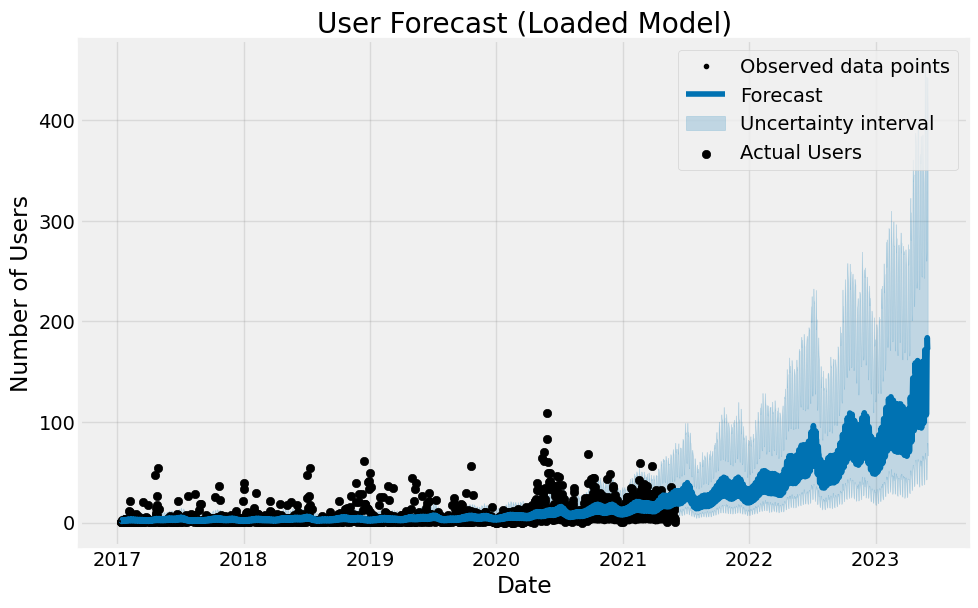

In [448]:
# Display the results
fig_new = model_new.plot(forecast_new)
plt.title('User Forecast (Loaded Model)')
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.scatter(df['ds'], df['y'], color='black', label='Actual Users')
plt.legend()
plt.show()


## **Comparison** between models

### Evaluation Metrics

#### Mean Absolute Error (MAE)
- **Definition:** MAE measures the average absolute differences between predicted and actual values.
- **Interpretation:** A lower MAE indicates better prediction accuracy, as it reflects the average magnitude of errors without considering their direction.

#### Root Mean Squared Error (RMSE)
- **Definition:** RMSE calculates the square root of the average of the squared differences between predicted and actual values.
- **Interpretation:** RMSE emphasizes larger errors due to squaring the differences, making it sensitive to outliers. A lower RMSE indicates a better fit of the model to the data.

#### Relative Absolute Error (RAE)
- **Definition:** RAE measures the total absolute error of the model's predictions relative to the total absolute error of a naive model that predicts the mean of the actual values.
- **Interpretation:** A lower RAE indicates that the model is more effective than simply predicting the mean. Values greater than 1 suggest that the model performs worse than the naive mean predictor.


In [449]:
# Define the metrics for each model
data = {
    'Model': ['Prophet', 'XGBoost', 'Linear Regression'],
    'MAE': [prophet_mae, mae_score_xgboost_mean, linear_regression_mean_mae],
    'RMSE (Overall)': [prophet_rmse, rmse_score_xgboost_mean, linear_regression_mean_rmse],
    'RAE': [prophet_rae, rae_score_xgboost_mean, linear_regression_mean_rae]
}

# Create a DataFrame
metrics_df = pd.DataFrame(data)

# Display the DataFrame
print(metrics_df)


               Model       MAE  RMSE (Overall)       RAE
0            Prophet  4.543198        8.972588  2.131478
1            XGBoost  6.758393       11.497030  0.975624
2  Linear Regression  2.574840        2.753417  4.330056


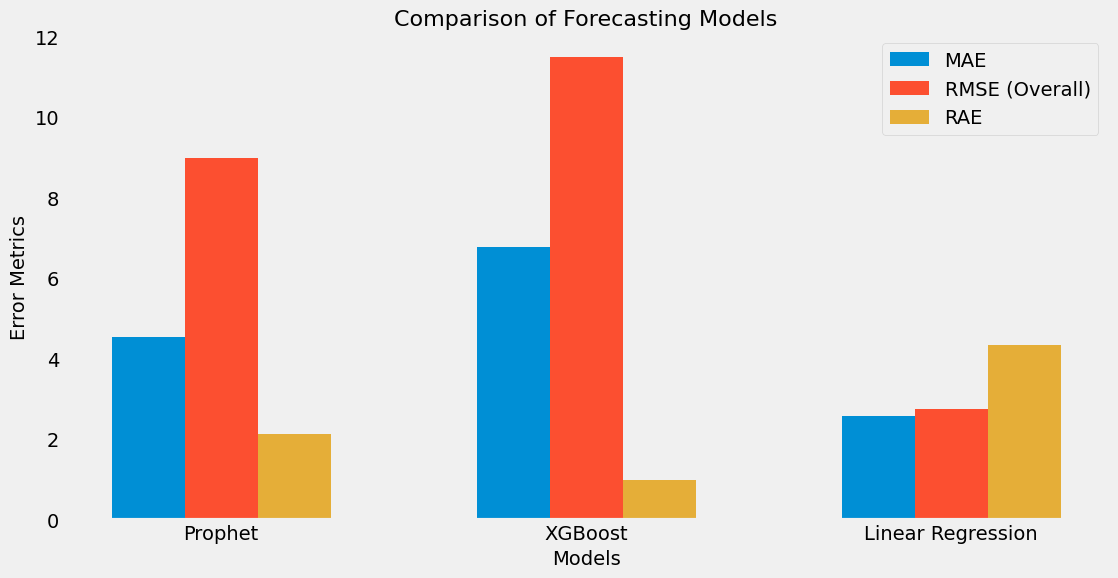

In [450]:
# Set the bar width
bar_width = 0.2
index = np.arange(len(metrics_df['Model']))

# Create a bar chart
plt.figure(figsize=(12, 6))
bar1 = plt.bar(index, metrics_df['MAE'].fillna(0), bar_width, label='MAE')
bar2 = plt.bar(index + bar_width, metrics_df['RMSE (Overall)'], bar_width, label='RMSE (Overall)')
bar3 = plt.bar(index + 2 * bar_width, metrics_df['RAE'].fillna(0), bar_width, label='RAE')

# Adding labels and title
plt.xlabel('Models', fontsize=14)
plt.ylabel('Error Metrics', fontsize=14)
plt.title('Comparison of Forecasting Models', fontsize=16)
plt.xticks(index + bar_width, metrics_df['Model'])
plt.legend()
plt.grid()
plt.show()


## Example of Future Predictions with Prophet

In [451]:
# Load the saved Prophet model
with open('prophet_model.pkl', 'rb') as f:
    model_new = pickle.load(f)


In [452]:
# Create a DataFrame for future predictions
future_new = model_new.make_future_dataframe(periods=730)  # Predict for one year ahead

# Perform the predictions
forecast_new = model_new.predict(future_new)

# Inverse the logarithmic transformation
forecast_new['yhat'] = np.expm1(forecast_new['yhat'])  # Use expm1 to revert to the original values
forecast_new['yhat_lower'] = np.expm1(forecast_new['yhat_lower'])
forecast_new['yhat_upper'] = np.expm1(forecast_new['yhat_upper'])

# Force yhat values to be >= 0
forecast_new['yhat'] = forecast_new['yhat'].clip(lower=0)
forecast_new['yhat_lower'] = forecast_new['yhat_lower'].clip(lower=0)
forecast_new['yhat_upper'] = forecast_new['yhat_upper'].clip(lower=0)


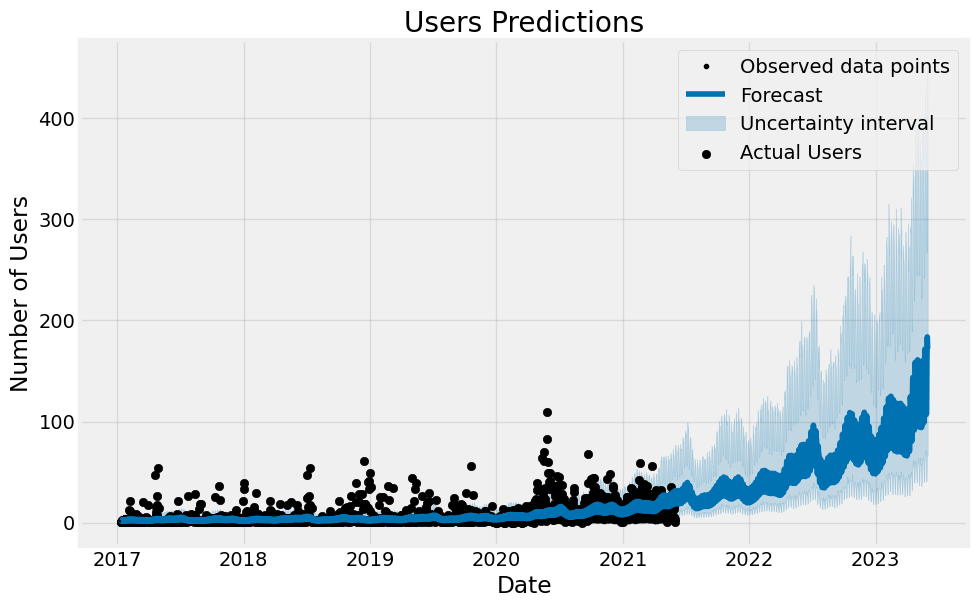

In [453]:
# Display the results
fig_new = model_new.plot(forecast_new)
plt.title('Users Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.scatter(df['ds'], df['y'], color='black', label='Actual Users')
plt.legend()
plt.show()


## Model Performance Summary

Based on the results presented in the table, we can draw several conclusions regarding the performance of the three models (Prophet, XGBoost, and Linear Regression):

### 1. Mean Absolute Error (MAE):
- **Linear Regression**: **2.57** - Lowest MAE, indicating predictions are closest to actual values.
- **Prophet**: **4.54** - Higher than Linear Regression, suggesting less accuracy.
- **XGBoost**: **6.76** - Highest MAE, indicating significant struggles with prediction accuracy.

### 2. Root Mean Squared Error (RMSE):
- **Linear Regression**: **2.75** - Best performance, with the least variance in prediction errors.
- **Prophet**: **8.97** - Higher RMSE indicates larger prediction errors than Linear Regression.
- **XGBoost**: **11.50** - Highest RMSE, suggesting poor performance, particularly for outliers.

### 3. Relative Absolute Error (RAE):
- **XGBoost**: **0.98** - Slightly better than a naive mean prediction model.
- **Prophet**: **2.13** - Performs worse than the mean prediction, indicating reliability issues.
- **Linear Regression**: **4.33** - Indicates that performance is less relative to the mean of the actual values.

### Overall Conclusion:
- **Linear Regression** stands out as the best-performing model, achieving the lowest MAE, RMSE, and an acceptable RAE. Its **simplicity and linear nature** enable it to capture essential relationships effectively.
- **Prophet** performs reasonably well but has a larger error margin, suggesting it may be less reliable for precise predictions in this context.
- **XGBoost** appears to have the weakest performance, particularly due to its higher error metrics, indicating it may not be as effective for this specific forecasting task.

### Reasons for Linear Regression's Superiority:
1. **Simplicity and Interpretability**: Captures linear relationships effectively, reducing overfitting risk.
2. **Feature Relationships**: Performs well when data exhibits linear trends.
3. **Fewer Parameters**: Reduces complexity, minimizing overfitting potential.
4. **Sensitivity to Outliers**: While sensitive, if outliers are not significant, performance remains strong.
5. **Context and Data Characteristics**: Outperforms in datasets with simple structures.
6. **Regularization**: Techniques can enhance robustness against overfitting.
